## C1. Environment Implementation

In [17]:
import gym
from gym import spaces
import numpy as np
import random as rand

class SimpleTrafficControlEnv(gym.Env):
  # create properties required for representing 
  # and update state of our traffic intersection
  def __init__(self):
    super(SimpleTrafficControlEnv, self).__init__()
    # action & observation spaces
    self.action_space = spaces.Discrete(2)
    self.observation_space = spaces.Discrete(4)
    self.state = np.array([1,0,0,0])
    # state names for use in lookups of transition and rewards dictionaries
    self.states = [
      'PhaseMain,TrafficMain',
      'PhaseMain,TrafficLeft',
      'PhaseLeft,TrafficMain',
      'PhaseLeft,TrafficLeft'
    ]
    # action names for use in lookups of transition and rewards dictionaries
    self.actions = [
      'PhaseMain',
      'PhaseLeft'
    ]
    # define our known discrete mdp environment
    # first we define our transition probabilities with respect to stochasticity mentioned in 2.2 above.
    self.transition_probs = {
        'PhaseMain,TrafficMain': {
            'PhaseMain': { 'PhaseMain,TrafficMain': 0.7, 'PhaseMain,TrafficLeft': 0.3},
            'PhaseLeft': { 'PhaseLeft,TrafficMain': 0.9, 'PhaseLeft,TrafficLeft': 0.1}
        },
        'PhaseMain,TrafficLeft': {
            'PhaseMain': { 'PhaseMain,TrafficMain': 0.2, 'PhaseMain,TrafficLeft': 0.8},
            'PhaseLeft': { 'PhaseLeft,TrafficLeft': 0.7, 'PhaseLeft,TrafficMain': 0.3}
        },
        'PhaseLeft,TrafficMain': {
            'PhaseLeft': { 'PhaseLeft,TrafficMain': 0.9, 'PhaseLeft,TrafficLeft': 0.1},
            'PhaseMain': { 'PhaseMain,TrafficMain': 0.9, 'PhaseMain,TrafficLeft': 0.1}
        },
        'PhaseLeft,TrafficLeft': {
            'PhaseLeft': { 'PhaseLeft,TrafficLeft': 0.7, 'PhaseLeft,TrafficMain': 0.3 },
            'PhaseMain': { 'PhaseMain,TrafficLeft': 0.6, 'PhaseMain,TrafficMain': 0.4 }
        }
    }
    # rewards defined in section 2.3 above
    self.rewards = {
      'PhaseMain,TrafficMain': { 
          'PhaseMain': { 'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': { 'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      },
      'PhaseLeft,TrafficMain': {
          'PhaseMain': {'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': {'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      },
      'PhaseMain,TrafficLeft': {
          'PhaseMain': {'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': {'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      },
      'PhaseLeft,TrafficLeft': {
          'PhaseMain': {'PhaseMain,TrafficMain': +1, 'PhaseMain,TrafficLeft': -2},
          'PhaseLeft': {'PhaseLeft,TrafficLeft': +1, 'PhaseLeft,TrafficMain': -2}
      }
    }
    rand.seed(None)

  # clean state
  def reset(self):
    # set initial state to PhaseMain,TrafficMain
    return np.array([1,0,0,0])

  # step through time using new action
  def step(self, action):
    old_state = self.get_state_name(self.state)
    # perform state updates based on new action
    self._perform(action) 
    new_state = self.get_state_name(self.state)
    # calculate reward
    reward = self.get_reward(old_state, self.actions[action], new_state) 

    # return new observations as well as reward
    # and done is always False in this environment
    return self.state, reward, False, {}
  
  def get_reward(self, state, action, next_state):
    if next_state in self.rewards[state][action]:
      return self.rewards[state][action][next_state]
    return -10 # large negative reward if attempting illegal move

  # given current state, and action, determine transition probability for new state
  def get_transition_prob(self, state, action, next_state):
    if next_state in env.transition_probs[state][action]:
      return env.transition_probs[state][action][next_state]
    return 0.0

  # update discrete space observation given state index
  def _set_state(self, state_index):
    new_state = np.array([0,0,0,0])
    new_state[state_index] = 1
    self.state = new_state

  # perform the state updates given selected action
  def _perform(self, action):
    assert self.action_space.contains(action)
    action_name = self.actions[action]
    new_state = self._get_new_state(action)
    self._set_state(self.states.index(new_state))

  def _get_new_state(self, action):
    # get a random number to use as the stochasticity
    # for action transitions
    random_value = rand.random()
    state_name = self.get_state_name(self.state)
    # get the non-zero transition probabilities for current state
    # from the transition probabilities dictionary
    transitions = self.transition_probs[state_name][self.actions[action]]
    
    # convert dictionary into tuple list
    # so that we can sort the list based on probability of transition
    items_list = [(k,v) for k,v in transitions.items()]
    items_list.sort(key=lambda x: x[1], reverse=True)

    # if the highest transition probability is greater
    # than the random number then we use that as the new state
    if random_value < items_list[0][1]:
      return items_list[0][0] # return the action with the highest probability
    else: # else we return a state with the lower probability of occurrence
      return items_list[1][0]

  # given discrete state space value, get the string representation of the state
  # this can then be used in lookup tables
  def get_state_name(self, state):
    return self.states[state.tolist().index(1)]


## C.2 Exact Policy Iteration

In [18]:
# Create transition matrix for our linear solve
import numpy as np
# Create class for capturing exact policy iteration logic
class ExactPolicyIteration:
  def __init__(self, env: SimpleTrafficControlEnv):
    # get a handle of the definition for our markov decision process
    self.env = env
    # this is our gamma / discount value
    self.discount = 0.9
    # initialize our policy function
    self.pi = { 
      'PhaseMain,TrafficMain': 'PhaseLeft',
      'PhaseMain,TrafficLeft': 'PhaseLeft',    
      'PhaseLeft,TrafficMain': 'PhaseLeft',
      'PhaseLeft,TrafficLeft': 'PhaseLeft'
    }

    # definition of the state rewards 'R' to use as our 'b' value in the closed form policy evaluation Ax = b
    self.rewards = np.array([+1,-2,-2,+1])
    self.v = np.array(len(env.states))
  
  # run policy iteration until converged at optimal policy
  def run(self):
    # create A matrix for Ax = b form
    A = self._create_A_matrix()
    # use new Ax = b closed for solution to calculate optimal state value function
    # for given policy
    self.v = self._evaluate_state_value_vector(A)
    print('v {0}'.format(self.v))
    # given new state value function
    # create new policy function
    new_policy, has_changed = self._update_policy()

    # if policy has changed
    # then we run the next policy iteration
    if has_changed:
      self.pi = new_policy
      self.run() # recursively loop until we have found the optimal policy
    # else we are finished policy iteration

  # get action based on state
  def get_policy_action(self, state):
    current_state = env.get_state_name(state)
    action_name = self.pi[current_state]
    return env.actions.index(action_name)

  # compute state action value
  def get_action_value(self, state, action):
    state_action_value = 0  
    for s_index in range(len(env.states)):
      s = env.states[s_index]
      # compute the state action value using bellman equation
      transition_probability = env.get_transition_prob(state, action, s)
      transition_reward = env.get_reward(state, action, s)
      # sum of all probable future rewards.
      state_action_value += transition_probability*(transition_reward + self.discount*self.v[s_index])

    return state_action_value


  # Construct our probability transition matrix,
  # and then from there we create our "A" matrix from our Ax = b linear system of equations
  # where x is our state-value vector.
  def _create_A_matrix(self):
    T = np.zeros((4,4)) # init transition probability matrix
    # create transition probability matrix with respect to current policy
    for row_index in range(len(env.states)):      
      for column_index in range(len(env.states)):
        state = env.states[row_index]
        next_state = env.states[column_index]
        T[row_index][column_index] = env.get_transition_prob(state, self.pi[state], next_state)
    
    # based on the work done in Task 3.1C we know the form of our A matrix
    # also as described by David Silver [4]
    A = (np.identity(4) - (self.discount * T)) 

    return A

  # Using our new A matrix and our awareness of the rewards at each state
  # we can calculate our new state value vector as a linear system of equations
  def _evaluate_state_value_vector(self, A):
    # refer to Lecture 2 by David Silver [4]
    return np.dot(np.linalg.inv(A), self.rewards)

  # using new state values vector, we calculate the best policy
  # based on material Sutton, Barto [3]
  def _update_policy(self):
    # create a copy of the existing policy
    pi_new = self.pi.copy()
    # keep track of whether we have changed the policy or not
    has_changed = False
    # loop through all state and find the best action for given that state
    for from_state in env.states:
      highest_reward = -99999 # init highest reward variable
      
      # loop through available actions & transition probabilities for state
      for action in env.actions:
        state_action_value = self.get_action_value(from_state, action)
        # choose highest value action
        if state_action_value > highest_reward:
          highest_reward = state_action_value
          pi_new[from_state] = action

      original_action = self.pi[from_state] # get original action for this state from previous policy
      if not original_action == pi_new[from_state]: # if they have changed we know that we are still able to improve our policy
        has_changed = True # ensure we inform the controlling loop that the policy has changed

    # return new policy, and whether the policy has changed at all
    return pi_new, has_changed

##  C.3 Learn Optimal Policy

In [19]:
# instantiate our exact policy iteration solution with our environment
env = SimpleTrafficControlEnv()
model = ExactPolicyIteration(env)

# run the policy iteration to calculate optimal policy ahead of time
model.run()

v [-11.13043478 -10.60869565 -14.13043478  -7.60869565]
v [ 2.47168167 -0.31658437 -0.02643044  2.68341563]


## C.4 Test

In [20]:
TIME_LIMIT = 1000

# Create new traffic control gym environment
total_reward = []
# Reset to clear state from potentialy earlier runs
o = env.reset() 
# for each time step
for t in range(TIME_LIMIT):
    # choose action from policy iteration model
    action = model.get_policy_action(o)

    # take step given action
    o, r, d, _ = env.step(action) 
    total_reward += [r]
else:
    print("Time limit reached.")
    print("Average reward {0}".format(np.mean(total_reward)))

Time limit reached.
Average reward 0.181


## C.5 Visualization

Next we define our MDP object to Visualize the MDP.
The MDP class is defined in a file given in practical 3.

> <b>Note:</b> Place mdp file in your google drive in the location referred to below.  


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


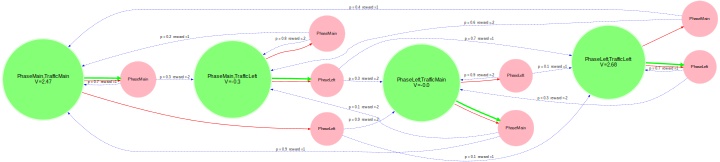

In [21]:
from google.colab import drive
import sys
from IPython.display import display


drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')

from mdp import has_graphviz
# if we dont have graphvizualization support
# then we don't need to run this cell
if has_graphviz:


  from mdp import MDP
  from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values

  mdp = MDP(env.transition_probs, env.rewards, initial_state='PhaseMain,TrafficMain')

  # define functino for aid in graph plotting below
  def get_action_value(mdp, state_values, state, action, gamma):
      return model.get_action_value(state, action)

  # create state-value mapping from states and value arrays
  state_values = {state: value for state,value in zip(env.states, model.v)}
  # render MDP as graph
  display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))